evaluate the model across a variety of single-token-prediction tasks

In [1]:
# Generic
from pathlib import Path
import typing

# Numerical Computing
import numpy as np
import torch
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ZanjHookedTransformer

# mechinterp stuff
from maze_transformer.mechinterp.logit_attrib_task import LOGIT_ATTRIB_TASKS
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data
from maze_transformer.evaluation.eval_single_token_tasks import TaskPrompts, TaskEvalResult, get_task_prompts_targets, eval_model_across_tasks, plot_task_accuracy

In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

# print the available tasks
print(f"{list(LOGIT_ATTRIB_TASKS.keys()) = }")

DEVICE = device(type='cuda')
list(LOGIT_ATTRIB_TASKS.keys()) = ['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']


expected tasks:
```
['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']
```

In [3]:
MODEL: ZanjHookedTransformer; DATASET: MazeDataset
MODEL, DATASET = load_model_with_test_data(
	model_path="../examples/wandb.jerpkipj.zanj",
	# model_path="../examples/model.hallway-insto.v17.zanj",
	# model_path="../examples/model.hallway-insto.final.zanj",
	# dataset_cfg_source=None,
	dataset_cfg_source=MazeDatasetConfig(
		name="hallway",
		grid_n=6,
		n_mazes=1,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
		maze_ctor_kwargs=dict(do_forks=False),
	),
	n_examples=100,
)

loaded model with 9.6M params (num_params = 9639484) from
../examples/wandb.jerpkipj.zanj
original model name: 'model.zanj_model_config.name = 'default'', changing to 'jerpkipj'
loaded dataset with 100 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g6-n100-a_dfs-h51432', 'sdc_hash': 21953628799579519491399527751453684974870664864302363176281422620152888051432, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 512, 'applied_filters': [], 'grid_n': 6, 'grid_shape': (6, 6), 'n_mazes': 100, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {'do_forks': False}}


In [4]:
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer

TASK_PROMPTS_TARGETS: TaskPrompts = get_task_prompts_targets(
	dataset=DATASET,
	maze_tokenizer=TOKENIZER,
	tasks=LOGIT_ATTRIB_TASKS,
)

In [5]:
TASK_RESULTS: dict[str, TaskEvalResult] = eval_model_across_tasks(
	model = MODEL,
	task_prompts = TASK_PROMPTS_TARGETS,
)

running task path_start
running task origin_after_path_start
running task first_path_choice
running task path_end
running task final_before_path_end
running task rand_path_token
running task rand_path_token_non_endpoint


acc_means = {'path_start': 1.0, 'origin_after_path_start': 0.8299999833106995, 'first_path_choice': 0.6600000262260437, 'path_end': 0.7400000095367432, 'final_before_path_end': 0.8999999761581421, 'rand_path_token': 0.8799999952316284, 'rand_path_token_non_endpoint': 0.9200000166893005}


Text(0.5, 1.0, "Prediction accuracy across tasks\nmodel: 'jerpkipj'\ndataset: 'hallway-g6-n100-a_dfs-h51432'")

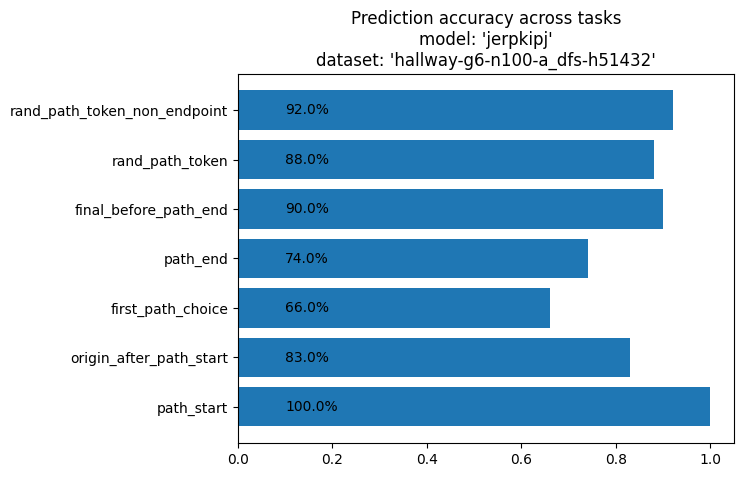

In [6]:
fig, ax = plot_task_accuracy(TASK_RESULTS)
plt.title(f"Prediction accuracy across tasks\nmodel: '{MODEL.config.name}'\ndataset: '{DATASET.cfg.to_fname()}'")